In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
%matplotlib inline

In [2]:
ms = pd.read_csv("ms_notes.csv", index_col=0)

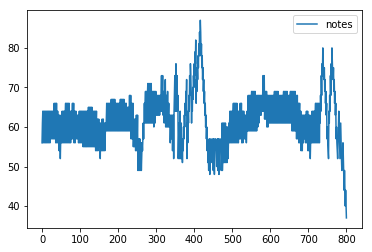

In [3]:
ms.plot()

## Simple RNN model with raw data

Our first attempt is to apply a simple RNN structure on the raw data and see if this performs well in terms of learning musical structures.  We will first try taking a difference of lag 1 and see if it works.

In [7]:
# Credit: Yuri Balasanov
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
raw_values = ms.notes.values
diff_values = difference(raw_values,1)
print('Raw values: ',raw_values[:10], '\nDifferencies:\n',diff_values[:10])

Raw values:  [56 61 64 56 61 64 56 61 64 56] 
Differencies:
 0    5
1    3
2   -8
3    5
4    3
5   -8
6    5
7    3
8   -8
9    5
dtype: int64


In [22]:
# Define RNN parameters
n_lag = 1
n_epochs = 1000
n_batch = 1
n_neurons = 10

In [23]:
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df
df_supervised=timeseries_to_supervised(diff_values,lag=n_lag)
df_supervised_values = df_supervised.values[n_lag:]
print(df_supervised_values[:10])

[[ 5.  3.]
 [ 3. -8.]
 [-8.  5.]
 [ 5.  3.]
 [ 3. -8.]
 [-8.  5.]
 [ 5.  3.]
 [ 3. -8.]
 [-8.  5.]
 [ 5.  3.]]


In [60]:
df_supervised_values.shape

(799, 2)

Train test split is optional as we are more interested in learning musical structure than actual prediction, but it can be good to have nonetheless.  Since every 3 notes in the time series represents a quarter time in 4/4, this means that there are 12 notes in each bar.  We can select a multiple of 12 as the test set so as to maintain the structure of the music.

In [24]:
train, test = df_supervised_values[0:-120], df_supervised_values[-120:]
print("Train: \n", train[:10], '\nTest: \n', test[:10])

Train: 
 [[ 5.  3.]
 [ 3. -8.]
 [-8.  5.]
 [ 5.  3.]
 [ 3. -8.]
 [-8.  5.]
 [ 5.  3.]
 [ 3. -8.]
 [-8.  5.]
 [ 5.  3.]] 
Test: 
 [[  3. -10.]
 [-10.   7.]
 [  7.   2.]
 [  2.  -9.]
 [ -9.   7.]
 [  7.   2.]
 [  2.  -7.]
 [ -7.   5.]
 [  5.   2.]
 [  2.  -6.]]


In [25]:
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
scaler, train_scaled, test_scaled = scale(train, test)
print('Train scaled: \n',train_scaled[:10],'\nTest scaled: \n',test_scaled[:10])

Train scaled: 
 [[ 0.5625  0.4375]
 [ 0.4375 -0.25  ]
 [-0.25    0.5625]
 [ 0.5625  0.4375]
 [ 0.4375 -0.25  ]
 [-0.25    0.5625]
 [ 0.5625  0.4375]
 [ 0.4375 -0.25  ]
 [-0.25    0.5625]
 [ 0.5625  0.4375]] 
Test scaled: 
 [[ 0.4375 -0.375 ]
 [-0.375   0.6875]
 [ 0.6875  0.375 ]
 [ 0.375  -0.3125]
 [-0.3125  0.6875]
 [ 0.6875  0.375 ]
 [ 0.375  -0.1875]
 [-0.1875  0.5625]
 [ 0.5625  0.375 ]
 [ 0.375  -0.125 ]]


In [26]:
train_trimmed = train_scaled[2:, :]
print('Trimmed data:\n',train_trimmed[:10])

Trimmed data:
 [[-0.25    0.5625]
 [ 0.5625  0.4375]
 [ 0.4375 -0.25  ]
 [-0.25    0.5625]
 [ 0.5625  0.4375]
 [ 0.4375 -0.25  ]
 [-0.25    0.5625]
 [ 0.5625  0.4375]
 [ 0.4375 -0.25  ]
 [-0.25    0.5625]]


In [27]:
X, y = train_trimmed[:, 0:-1], train_trimmed[:, -1]
print('Shape X: ',X.shape)
print('X:\n',X[:10],'\ny:\n',y[:10])

Shape X:  (677, 1)
X:
 [[-0.25  ]
 [ 0.5625]
 [ 0.4375]
 [-0.25  ]
 [ 0.5625]
 [ 0.4375]
 [-0.25  ]
 [ 0.5625]
 [ 0.4375]
 [-0.25  ]] 
y:
 [ 0.5625  0.4375 -0.25    0.5625  0.4375 -0.25    0.5625  0.4375 -0.25
  0.5625]


In [28]:
X = X.reshape(X.shape[0], 1, X.shape[1])
print(X.shape)
print('X:\n',X[:5])

(677, 1, 1)
X:
 [[[-0.25  ]]

 [[ 0.5625]]

 [[ 0.4375]]

 [[-0.25  ]]

 [[ 0.5625]]]


In [29]:
input_shape = (n_batch, X.shape[1], X.shape[2])
def make_model(n_batch,n_neurons):
    model = Sequential()
    model.add(SimpleRNN(n_neurons, batch_input_shape=input_shape, stateful=False))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
rnn_model=make_model(n_batch,n_neurons)
rnn_model.compile(loss='mean_squared_error', optimizer='adam')

In [30]:
rnn_model.fit(X, y, epochs=n_epochs, batch_size=n_batch, verbose=1, shuffle=False)

Epoch 1/1000
677/677 [==============================] - 1s 1ms/step - loss: 0.1168A: 0s - loss: 0.
Epoch 2/1000
677/677 [==============================] - 1s 833us/step - loss: 0.1036 0s - loss: 0
Epoch 3/1000
677/677 [==============================] - 1s 975us/step - loss: 0.1036
Epoch 4/1000
677/677 [==============================] - 1s 907us/step - loss: 0.1036
Epoch 5/1000
677/677 [==============================] - 1s 920us/step - loss: 0.1035 0s - loss: 0.10
Epoch 6/1000
677/677 [==============================] - 1s 955us/step - loss: 0.1035
Epoch 7/1000
677/677 [==============================] - 1s 938us/step - loss: 0.1035 0s - loss: 0.
Epoch 8/1000
677/677 [==============================] - 1s 836us/step - loss: 0.1034
Epoch 9/1000
677/677 [==============================] - 1s 801us/step - loss: 0.1034 0s - loss: 0.1
Epoch 10/1000
677/677 [==============================] - 1s 838us/step - loss: 0.1034 0s - loss: 0.102
Epoch 11/1000
677/677 [==============================] - 1s 

677/677 [==============================] - 1s 978us/step - loss: 0.0981
Epoch 96/1000
677/677 [==============================] - 1s 982us/step - loss: 0.0980
Epoch 97/1000
677/677 [==============================] - 1s 942us/step - loss: 0.0980
Epoch 98/1000
677/677 [==============================] - 1s 990us/step - loss: 0.0979
Epoch 99/1000
677/677 [==============================] - 1s 1ms/step - loss: 0.0979
Epoch 100/1000
677/677 [==============================] - 1s 1ms/step - loss: 0.0978
Epoch 101/1000
677/677 [==============================] - 1s 1ms/step - loss: 0.0978
Epoch 102/1000
677/677 [==============================] - 1s 1ms/step - loss: 0.0978
Epoch 103/1000
677/677 [==============================] - 1s 1ms/step - loss: 0.0977
Epoch 104/1000
677/677 [==============================] - 1s 1ms/step - loss: 0.0977
Epoch 105/1000
677/677 [==============================] - 1s 995us/step - loss: 0.0976
Epoch 106/1000
677/677 [==============================] - 1s 1ms/step - lo

677/677 [==============================] - 1s 927us/step - loss: 0.0961
Epoch 189/1000
677/677 [==============================] - 1s 984us/step - loss: 0.0961
Epoch 190/1000
677/677 [==============================] - 1s 969us/step - loss: 0.0960
Epoch 191/1000
677/677 [==============================] - 1s 939us/step - loss: 0.0960
Epoch 192/1000
677/677 [==============================] - 1s 964us/step - loss: 0.0960
Epoch 193/1000
677/677 [==============================] - 1s 838us/step - loss: 0.0960 0s - loss: 0.0
Epoch 194/1000
677/677 [==============================] - 1s 947us/step - loss: 0.0960
Epoch 195/1000
677/677 [==============================] - 1s 937us/step - loss: 0.0960
Epoch 196/1000
677/677 [==============================] - 1s 903us/step - loss: 0.0959
Epoch 197/1000
677/677 [==============================] - 1s 878us/step - loss: 0.0959
Epoch 198/1000
677/677 [==============================] - 1s 967us/step - loss: 0.0959
Epoch 199/1000
677/677 [===================

677/677 [==============================] - 1s 975us/step - loss: 0.0947
Epoch 282/1000
677/677 [==============================] - 1s 1ms/step - loss: 0.0947
Epoch 283/1000
677/677 [==============================] - 1s 1ms/step - loss: 0.0947
Epoch 284/1000
677/677 [==============================] - 1s 970us/step - loss: 0.0947
Epoch 285/1000
677/677 [==============================] - 1s 1ms/step - loss: 0.0947
Epoch 286/1000
677/677 [==============================] - 1s 950us/step - loss: 0.0947
Epoch 287/1000
677/677 [==============================] - 1s 953us/step - loss: 0.0947
Epoch 288/1000
677/677 [==============================] - 1s 998us/step - loss: 0.0946
Epoch 289/1000
677/677 [==============================] - 1s 970us/step - loss: 0.0946
Epoch 290/1000
677/677 [==============================] - 1s 981us/step - loss: 0.0946
Epoch 291/1000
677/677 [==============================] - 1s 991us/step - loss: 0.0946
Epoch 292/1000
677/677 [==============================] - 1s 978

677/677 [==============================] - 1s 976us/step - loss: 0.0940 0s - loss: 0.09
Epoch 374/1000
677/677 [==============================] - 1s 943us/step - loss: 0.0940
Epoch 375/1000
677/677 [==============================] - 1s 932us/step - loss: 0.0940
Epoch 376/1000
677/677 [==============================] - 1s 857us/step - loss: 0.0940
Epoch 377/1000
677/677 [==============================] - 1s 938us/step - loss: 0.0940
Epoch 378/1000
677/677 [==============================] - 1s 944us/step - loss: 0.0940
Epoch 379/1000
677/677 [==============================] - 1s 941us/step - loss: 0.0940 0s - loss: 0
Epoch 380/1000
677/677 [==============================] - 1s 951us/step - loss: 0.0940
Epoch 381/1000
677/677 [==============================] - 1s 936us/step - loss: 0.0940
Epoch 382/1000
677/677 [==============================] - 1s 952us/step - loss: 0.0940
Epoch 383/1000
677/677 [==============================] - 1s 971us/step - loss: 0.0940
Epoch 384/1000
677/677 [=====

677/677 [==============================] - 1s 970us/step - loss: 0.0937
Epoch 465/1000
677/677 [==============================] - 1s 906us/step - loss: 0.0937
Epoch 466/1000
677/677 [==============================] - 1s 868us/step - loss: 0.0937
Epoch 467/1000
677/677 [==============================] - 1s 879us/step - loss: 0.0937
Epoch 468/1000
677/677 [==============================] - 1s 857us/step - loss: 0.0937
Epoch 469/1000
677/677 [==============================] - 1s 953us/step - loss: 0.0937
Epoch 470/1000
677/677 [==============================] - 1s 982us/step - loss: 0.0937
Epoch 471/1000
677/677 [==============================] - 1s 1ms/step - loss: 0.0937
Epoch 472/1000
677/677 [==============================] - 1s 954us/step - loss: 0.0937 0s - loss: 0
Epoch 473/1000
677/677 [==============================] - 1s 967us/step - loss: 0.0937
Epoch 474/1000
677/677 [==============================] - 1s 1ms/step - loss: 0.0937
Epoch 475/1000
677/677 [=========================

677/677 [==============================] - 1s 937us/step - loss: 0.0936
Epoch 557/1000
677/677 [==============================] - 1s 917us/step - loss: 0.0935
Epoch 558/1000
677/677 [==============================] - 1s 920us/step - loss: 0.0935
Epoch 559/1000
677/677 [==============================] - 1s 808us/step - loss: 0.0935
Epoch 560/1000
677/677 [==============================] - 1s 870us/step - loss: 0.0935
Epoch 561/1000
677/677 [==============================] - 1s 781us/step - loss: 0.0935
Epoch 562/1000
677/677 [==============================] - 1s 867us/step - loss: 0.0935
Epoch 563/1000
677/677 [==============================] - 1s 877us/step - loss: 0.0935
Epoch 564/1000
677/677 [==============================] - 1s 918us/step - loss: 0.0935
Epoch 565/1000
677/677 [==============================] - 1s 824us/step - loss: 0.0935: 0s - loss: 
Epoch 566/1000
677/677 [==============================] - 1s 843us/step - loss: 0.0935
Epoch 567/1000
677/677 [=====================

677/677 [==============================] - 1s 959us/step - loss: 0.0934
Epoch 650/1000
677/677 [==============================] - 1s 959us/step - loss: 0.0934
Epoch 651/1000
677/677 [==============================] - 1s 949us/step - loss: 0.0934
Epoch 652/1000
677/677 [==============================] - 1s 911us/step - loss: 0.0934 0s - loss:  - ETA: 0s - loss: 0.093
Epoch 653/1000
677/677 [==============================] - 1s 914us/step - loss: 0.0934
Epoch 654/1000
677/677 [==============================] - 1s 916us/step - loss: 0.0934: 0s - loss
Epoch 655/1000
677/677 [==============================] - 1s 885us/step - loss: 0.0934
Epoch 656/1000
677/677 [==============================] - 1s 892us/step - loss: 0.0934
Epoch 657/1000
677/677 [==============================] - 1s 866us/step - loss: 0.0934
Epoch 658/1000
677/677 [==============================] - 1s 872us/step - loss: 0.0934 0s - loss: 0. - ETA: 0s - loss: 0.094
Epoch 659/1000
677/677 [==============================] - 1s

677/677 [==============================] - 1s 880us/step - loss: 0.0933
Epoch 741/1000
677/677 [==============================] - 1s 890us/step - loss: 0.0933
Epoch 742/1000
677/677 [==============================] - 1s 879us/step - loss: 0.0933
Epoch 743/1000
677/677 [==============================] - 1s 915us/step - loss: 0.0933
Epoch 744/1000
677/677 [==============================] - 1s 921us/step - loss: 0.0933
Epoch 745/1000
677/677 [==============================] - 1s 972us/step - loss: 0.0933
Epoch 746/1000
677/677 [==============================] - 1s 957us/step - loss: 0.0933
Epoch 747/1000
677/677 [==============================] - 1s 955us/step - loss: 0.0933
Epoch 748/1000
677/677 [==============================] - 1s 937us/step - loss: 0.0933
Epoch 749/1000
677/677 [==============================] - 1s 1ms/step - loss: 0.0933
Epoch 750/1000
677/677 [==============================] - 1s 981us/step - loss: 0.0933 0s - loss:  - ETA: 0s - loss: 0.093
Epoch 751/1000
677/677 [

677/677 [==============================] - 1s 879us/step - loss: 0.0932
Epoch 832/1000
677/677 [==============================] - 1s 804us/step - loss: 0.0932
Epoch 833/1000
677/677 [==============================] - 1s 779us/step - loss: 0.0932
Epoch 834/1000
677/677 [==============================] - 1s 839us/step - loss: 0.0932
Epoch 835/1000
677/677 [==============================] - 1s 839us/step - loss: 0.0932
Epoch 836/1000
677/677 [==============================] - 1s 888us/step - loss: 0.0932
Epoch 837/1000
677/677 [==============================] - 1s 914us/step - loss: 0.0932
Epoch 838/1000
677/677 [==============================] - 1s 845us/step - loss: 0.0932
Epoch 839/1000
677/677 [==============================] - 1s 865us/step - loss: 0.0932 0s - loss: 0.0
Epoch 840/1000
677/677 [==============================] - 1s 877us/step - loss: 0.0932
Epoch 841/1000
677/677 [==============================] - 1s 830us/step - loss: 0.0932
Epoch 842/1000
677/677 [===================

677/677 [==============================] - 1s 965us/step - loss: 0.0931
Epoch 924/1000
677/677 [==============================] - 1s 1ms/step - loss: 0.0930
Epoch 925/1000
677/677 [==============================] - 1s 1ms/step - loss: 0.0930
Epoch 926/1000
677/677 [==============================] - 1s 1ms/step - loss: 0.0930
Epoch 927/1000
677/677 [==============================] - 1s 1ms/step - loss: 0.0930
Epoch 928/1000
677/677 [==============================] - 1s 1ms/step - loss: 0.0930
Epoch 929/1000
677/677 [==============================] - 1s 1ms/step - loss: 0.0930
Epoch 930/1000
677/677 [==============================] - 1s 1ms/step - loss: 0.0930
Epoch 931/1000
677/677 [==============================] - 1s 1ms/step - loss: 0.0930
Epoch 932/1000
677/677 [==============================] - 1s 1ms/step - loss: 0.0930
Epoch 933/1000
677/677 [==============================] - 1s 941us/step - loss: 0.0930
Epoch 934/1000
677/677 [==============================] - 1s 978us/step - lo

In [31]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [32]:
test_reshaped = test_scaled[:, 0:-1]
test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
print('Test scaled: \n',test_scaled)
print('\nTest reshaped: \n',test_reshaped)

Test scaled: 
 [[ 0.4375 -0.375 ]
 [-0.375   0.6875]
 [ 0.6875  0.375 ]
 [ 0.375  -0.3125]
 [-0.3125  0.6875]
 [ 0.6875  0.375 ]
 [ 0.375  -0.1875]
 [-0.1875  0.5625]
 [ 0.5625  0.375 ]
 [ 0.375  -0.125 ]
 [-0.125   0.5   ]
 [ 0.5     0.375 ]
 [ 0.375  -0.1875]
 [-0.1875  0.5625]
 [ 0.5625  0.4375]
 [ 0.4375 -0.25  ]
 [-0.25    0.5625]
 [ 0.5625  0.4375]
 [ 0.4375 -0.375 ]
 [-0.375   0.625 ]
 [ 0.625   0.4375]
 [ 0.4375 -0.3125]
 [-0.3125  0.625 ]
 [ 0.625   0.4375]
 [ 0.4375 -0.4375]
 [-0.4375  0.5   ]
 [ 0.5     0.5625]
 [ 0.5625 -0.0625]
 [-0.0625  0.5625]
 [ 0.5625  0.4375]
 [ 0.4375 -0.25  ]
 [-0.25    0.5625]
 [ 0.5625  0.4375]
 [ 0.4375 -0.25  ]
 [-0.25    0.5625]
 [ 0.5625  0.4375]
 [ 0.4375 -0.25  ]
 [-0.25    0.6875]
 [ 0.6875  0.4375]
 [ 0.4375 -0.375 ]
 [-0.375   0.6875]
 [ 0.6875  0.4375]
 [ 0.4375 -0.375 ]
 [-0.375   0.6875]
 [ 0.6875  0.4375]
 [ 0.4375 -0.375 ]
 [-0.375   0.6875]
 [ 0.6875  0.4375]
 [ 0.4375 -0.375 ]
 [-0.375   0.75  ]
 [ 0.75    0.0625]
 [ 0.0625  0.687

In [33]:
output = rnn_model.predict(test_reshaped, batch_size=n_batch)
print('Output: \n',output)

Output: 
 [[ 0.03782508]
 [ 0.6012141 ]
 [ 0.21929845]
 [-0.01650229]
 [ 0.5697936 ]
 [ 0.21929845]
 [-0.01650229]
 [ 0.5051354 ]
 [ 0.14182693]
 [-0.01650229]
 [ 0.49113822]
 [ 0.09262936]
 [-0.01650229]
 [ 0.5051354 ]
 [ 0.14182693]
 [ 0.03782508]
 [ 0.53451234]
 [ 0.14182693]
 [ 0.03782508]
 [ 0.6012141 ]
 [ 0.18401827]
 [ 0.03782508]
 [ 0.5697936 ]
 [ 0.18401827]
 [ 0.03782508]
 [ 0.6226264 ]
 [ 0.09262936]
 [ 0.14182693]
 [ 0.49614096]
 [ 0.14182693]
 [ 0.03782508]
 [ 0.53451234]
 [ 0.14182693]
 [ 0.03782508]
 [ 0.53451234]
 [ 0.14182693]
 [ 0.03782508]
 [ 0.53451234]
 [ 0.21929845]
 [ 0.03782508]
 [ 0.6012141 ]
 [ 0.21929845]
 [ 0.03782508]
 [ 0.6012141 ]
 [ 0.21929845]
 [ 0.03782508]
 [ 0.6012141 ]
 [ 0.21929845]
 [ 0.03782508]
 [ 0.6012141 ]
 [ 0.24824797]
 [ 0.50019354]
 [ 0.21929845]
 [ 0.51090586]
 [ 0.2715947 ]
 [ 0.49614096]
 [ 0.24824797]
 [ 0.50019354]
 [ 0.21929845]
 [ 0.51090586]
 [ 0.50019354]
 [ 0.16743125]
 [ 0.03782508]
 [ 0.49113822]
 [ 0.03782508]
 [ 0.49113822]


In [36]:
predictions = list()
for i in range(len(output)):
    yhat = output[i, 0]
    X = test_scaled[i, 0:-1]
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled) + 1 - i)
    # store forecast
    predictions.append(np.round_(yhat))
print('Raw values and predictions:\n',np.column_stack((raw_values[-120:],predictions)))

Raw values and predictions:
 [[54. 61.]
 [61. 60.]
 [63. 61.]
 [54. 59.]
 [61. 59.]
 [63. 61.]
 [56. 59.]
 [61. 60.]
 [63. 59.]
 [57. 59.]
 [61. 61.]
 [63. 58.]
 [56. 59.]
 [61. 60.]
 [64. 59.]
 [56. 61.]
 [61. 61.]
 [64. 59.]
 [54. 61.]
 [60. 60.]
 [63. 59.]
 [54. 60.]
 [60. 59.]
 [63. 59.]
 [52. 60.]
 [56. 58.]
 [61. 53.]
 [56. 59.]
 [61. 60.]
 [64. 59.]
 [56. 61.]
 [61. 61.]
 [64. 59.]
 [56. 61.]
 [61. 61.]
 [64. 59.]
 [56. 61.]
 [63. 61.]
 [66. 63.]
 [56. 63.]
 [63. 62.]
 [66. 63.]
 [56. 63.]
 [63. 62.]
 [66. 63.]
 [56. 63.]
 [63. 62.]
 [66. 63.]
 [56. 63.]
 [64. 62.]
 [61. 64.]
 [68. 65.]
 [64. 68.]
 [73. 68.]
 [68. 73.]
 [76. 72.]
 [73. 76.]
 [80. 77.]
 [76. 80.]
 [73. 80.]
 [72. 77.]
 [75. 71.]
 [69. 72.]
 [72. 73.]
 [66. 69.]
 [69. 70.]
 [63. 66.]
 [66. 67.]
 [57. 63.]
 [60. 62.]
 [56. 57.]
 [54. 60.]
 [52. 56.]
 [64. 54.]
 [61. 65.]
 [68. 65.]
 [64. 68.]
 [73. 68.]
 [68. 73.]
 [76. 72.]
 [73. 76.]
 [80. 77.]
 [76. 80.]
 [73. 80.]
 [72. 77.]
 [75. 71.]
 [69. 72.]
 [72. 73.]
 [6

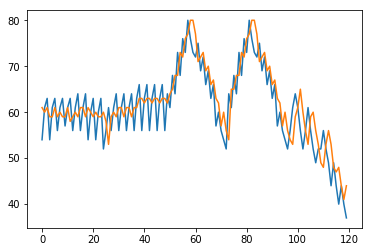

In [41]:
plt.plot(raw_values[-120:])
plt.plot(predictions)

As we can see, while RNN learned to pick up how the notes overall was moving up and down, it is not learning the three-note sequence structure in this song.  We can go ahead and try LSTM to see whether additional memory will be able to overcome the problem.

Another idea is to have a modified the structure of the simple model so as to work better with the structure of this particular piece, which consists of repeating 3-note patterns throughout the song. In order to reflect the structure of the song, we can make the unit of input and output of each prediction to be 3 notes instead of 1, i.e. they both become a vector of three dimensions.  We can also modify the loss function so that it consists of two parts: first, the deviance of the predictions to the actual; second, whether the 3 note pattern is a "valid chord", which we can define as belonging to minor, major, or even diminished.  This way we can make sure that the patterns generated is "musical" in the classical sense.

In [68]:
# Data prep - make three-note sequences as input and output
# Original shape: 801, 1
# Reshaped into 267, 3 (i.e. 267*3 note sequences)

X = ms.values.reshape((267,3))[:-1]
y = ms.values.reshape((267,3))[1:]

In [73]:
X.shape

(266, 3)

In [110]:
# Define RNN parameters

n_epochs = 1000
n_batch = 226
n_neurons = 10

In [86]:
# Train-test split, maybe not so necessary but we will use it to gauge performance
X_train, X_test = X[0:-40], X[-40:]
y_train, y_test = y[0:-40], y[-40:]

In [122]:
y.shape

(266, 3)

In [107]:
X_train_reshaped = X_train.reshape((226, 1, 3))
X_test_reshaped = X_test.reshape((40, 1, 3))

In [123]:

input_shape = (n_batch, 1, X.shape[1])
def make_model(input_shape,n_neurons):
    model = Sequential()
    model.add(SimpleRNN(n_neurons, batch_input_shape=input_shape, stateful=False))
    model.add(Dense(3))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
rnn_model_3=make_model(input_shape,n_neurons)
rnn_model_3.compile(loss='mean_squared_error', optimizer='adam')

In [113]:
rnn_model_3.fit(X_train_reshaped, y_train,epochs=5000, batch_size=n_batch, verbose=1, shuffle=False)

Epoch 1/5000
226/226 [==============================] - 0s 9us/step - loss: 12.2800
Epoch 2/5000
226/226 [==============================] - 0s 12us/step - loss: 12.2792
Epoch 3/5000
226/226 [==============================] - 0s 12us/step - loss: 12.2797
Epoch 4/5000
226/226 [==============================] - 0s 16us/step - loss: 12.2829
Epoch 5/5000
226/226 [==============================] - 0s 12us/step - loss: 12.2887
Epoch 6/5000
226/226 [==============================] - 0s 9us/step - loss: 12.3010
Epoch 7/5000
226/226 [==============================] - 0s 8us/step - loss: 12.3128
Epoch 8/5000
226/226 [==============================] - 0s 7us/step - loss: 12.3304
Epoch 9/5000
226/226 [==============================] - 0s 13us/step - loss: 12.3249
Epoch 10/5000
226/226 [==============================] - 0s 8us/step - loss: 12.3100
Epoch 11/5000
226/226 [==============================] - 0s 10us/step - loss: 12.2732
Epoch 12/5000
226/226 [==============================] - 0s 11us/ste

Epoch 97/5000
226/226 [==============================] - 0s 8us/step - loss: 12.0121
Epoch 98/5000
226/226 [==============================] - 0s 10us/step - loss: 12.0094
Epoch 99/5000
226/226 [==============================] - 0s 11us/step - loss: 12.0067
Epoch 100/5000
226/226 [==============================] - 0s 12us/step - loss: 12.0040
Epoch 101/5000
226/226 [==============================] - 0s 11us/step - loss: 12.0013
Epoch 102/5000
226/226 [==============================] - 0s 9us/step - loss: 11.9986
Epoch 103/5000
226/226 [==============================] - 0s 8us/step - loss: 11.9959
Epoch 104/5000
226/226 [==============================] - 0s 16us/step - loss: 11.9932
Epoch 105/5000
226/226 [==============================] - 0s 8us/step - loss: 11.9906
Epoch 106/5000
226/226 [==============================] - 0s 10us/step - loss: 11.9879
Epoch 107/5000
226/226 [==============================] - 0s 10us/step - loss: 11.9852
Epoch 108/5000
226/226 [==========================

Epoch 192/5000
226/226 [==============================] - 0s 16us/step - loss: 11.7626
Epoch 193/5000
226/226 [==============================] - 0s 11us/step - loss: 11.7614
Epoch 194/5000
226/226 [==============================] - 0s 9us/step - loss: 11.7612
Epoch 195/5000
226/226 [==============================] - 0s 11us/step - loss: 11.7629
Epoch 196/5000
226/226 [==============================] - 0s 11us/step - loss: 11.7669
Epoch 197/5000
226/226 [==============================] - 0s 9us/step - loss: 11.7760
Epoch 198/5000
226/226 [==============================] - 0s 10us/step - loss: 11.7875
Epoch 199/5000
226/226 [==============================] - 0s 9us/step - loss: 11.8067
Epoch 200/5000
226/226 [==============================] - 0s 8us/step - loss: 11.8141
Epoch 201/5000
226/226 [==============================] - 0s 11us/step - loss: 11.8162
Epoch 202/5000
226/226 [==============================] - 0s 8us/step - loss: 11.7850
Epoch 203/5000
226/226 [========================

Epoch 287/5000
226/226 [==============================] - 0s 19us/step - loss: 11.5245
Epoch 288/5000
226/226 [==============================] - 0s 12us/step - loss: 11.5220
Epoch 289/5000
226/226 [==============================] - 0s 14us/step - loss: 11.5196
Epoch 290/5000
226/226 [==============================] - 0s 15us/step - loss: 11.5172
Epoch 291/5000
226/226 [==============================] - 0s 9us/step - loss: 11.5147
Epoch 292/5000
226/226 [==============================] - 0s 9us/step - loss: 11.5123
Epoch 293/5000
226/226 [==============================] - 0s 12us/step - loss: 11.5099
Epoch 294/5000
226/226 [==============================] - 0s 10us/step - loss: 11.5075
Epoch 295/5000
226/226 [==============================] - 0s 8us/step - loss: 11.5050
Epoch 296/5000
226/226 [==============================] - 0s 12us/step - loss: 11.5026
Epoch 297/5000
226/226 [==============================] - 0s 17us/step - loss: 11.5002
Epoch 298/5000
226/226 [======================

Epoch 382/5000
226/226 [==============================] - 0s 12us/step - loss: 11.2980
Epoch 383/5000
226/226 [==============================] - 0s 10us/step - loss: 11.2956
Epoch 384/5000
226/226 [==============================] - 0s 8us/step - loss: 11.2933
Epoch 385/5000
226/226 [==============================] - 0s 10us/step - loss: 11.2910
Epoch 386/5000
226/226 [==============================] - 0s 20us/step - loss: 11.2887
Epoch 387/5000
226/226 [==============================] - 0s 10us/step - loss: 11.2864
Epoch 388/5000
226/226 [==============================] - 0s 8us/step - loss: 11.2841
Epoch 389/5000
226/226 [==============================] - 0s 9us/step - loss: 11.2818
Epoch 390/5000
226/226 [==============================] - 0s 9us/step - loss: 11.2796
Epoch 391/5000
226/226 [==============================] - 0s 9us/step - loss: 11.2774
Epoch 392/5000
226/226 [==============================] - 0s 10us/step - loss: 11.2753
Epoch 393/5000
226/226 [========================

Epoch 477/5000
226/226 [==============================] - 0s 7us/step - loss: 11.0841
Epoch 478/5000
226/226 [==============================] - 0s 12us/step - loss: 11.0819
Epoch 479/5000
226/226 [==============================] - 0s 9us/step - loss: 11.0797
Epoch 480/5000
226/226 [==============================] - 0s 9us/step - loss: 11.0775
Epoch 481/5000
226/226 [==============================] - 0s 12us/step - loss: 11.0753
Epoch 482/5000
226/226 [==============================] - 0s 8us/step - loss: 11.0731
Epoch 483/5000
226/226 [==============================] - 0s 11us/step - loss: 11.0709
Epoch 484/5000
226/226 [==============================] - 0s 8us/step - loss: 11.0687
Epoch 485/5000
226/226 [==============================] - 0s 11us/step - loss: 11.0665
Epoch 486/5000
226/226 [==============================] - 0s 10us/step - loss: 11.0643
Epoch 487/5000
226/226 [==============================] - 0s 9us/step - loss: 11.0622
Epoch 488/5000
226/226 [=========================

Epoch 572/5000
226/226 [==============================] - 0s 14us/step - loss: 10.8796
Epoch 573/5000
226/226 [==============================] - 0s 8us/step - loss: 10.8775
Epoch 574/5000
226/226 [==============================] - 0s 10us/step - loss: 10.8754
Epoch 575/5000
226/226 [==============================] - 0s 9us/step - loss: 10.8733
Epoch 576/5000
226/226 [==============================] - 0s 11us/step - loss: 10.8712
Epoch 577/5000
226/226 [==============================] - 0s 9us/step - loss: 10.8691
Epoch 578/5000
226/226 [==============================] - 0s 13us/step - loss: 10.8670
Epoch 579/5000
226/226 [==============================] - 0s 11us/step - loss: 10.8649
Epoch 580/5000
226/226 [==============================] - 0s 12us/step - loss: 10.8628
Epoch 581/5000
226/226 [==============================] - 0s 7us/step - loss: 10.8607
Epoch 582/5000
226/226 [==============================] - 0s 8us/step - loss: 10.8586
Epoch 583/5000
226/226 [========================

Epoch 667/5000
226/226 [==============================] - 0s 16us/step - loss: 10.6861
Epoch 668/5000
226/226 [==============================] - 0s 9us/step - loss: 10.6841
Epoch 669/5000
226/226 [==============================] - 0s 10us/step - loss: 10.6820
Epoch 670/5000
226/226 [==============================] - 0s 13us/step - loss: 10.6800
Epoch 671/5000
226/226 [==============================] - 0s 8us/step - loss: 10.6781
Epoch 672/5000
226/226 [==============================] - 0s 12us/step - loss: 10.6761
Epoch 673/5000
226/226 [==============================] - 0s 9us/step - loss: 10.6741
Epoch 674/5000
226/226 [==============================] - 0s 13us/step - loss: 10.6722
Epoch 675/5000
226/226 [==============================] - 0s 11us/step - loss: 10.6702
Epoch 676/5000
226/226 [==============================] - 0s 12us/step - loss: 10.6682
Epoch 677/5000
226/226 [==============================] - 0s 9us/step - loss: 10.6662
Epoch 678/5000
226/226 [=======================

Epoch 762/5000
226/226 [==============================] - 0s 12us/step - loss: 10.5013
Epoch 763/5000
226/226 [==============================] - 0s 8us/step - loss: 10.4994
Epoch 764/5000
226/226 [==============================] - 0s 10us/step - loss: 10.4975
Epoch 765/5000
226/226 [==============================] - 0s 13us/step - loss: 10.4956
Epoch 766/5000
226/226 [==============================] - 0s 12us/step - loss: 10.4937
Epoch 767/5000
226/226 [==============================] - 0s 11us/step - loss: 10.4918
Epoch 768/5000
226/226 [==============================] - 0s 8us/step - loss: 10.4899
Epoch 769/5000
226/226 [==============================] - 0s 13us/step - loss: 10.4880
Epoch 770/5000
226/226 [==============================] - 0s 16us/step - loss: 10.4861
Epoch 771/5000
226/226 [==============================] - 0s 8us/step - loss: 10.4843
Epoch 772/5000
226/226 [==============================] - 0s 7us/step - loss: 10.4824
Epoch 773/5000
226/226 [=======================

Epoch 857/5000
226/226 [==============================] - 0s 9us/step - loss: 10.3264
Epoch 858/5000
226/226 [==============================] - 0s 11us/step - loss: 10.3247
Epoch 859/5000
226/226 [==============================] - 0s 10us/step - loss: 10.3229
Epoch 860/5000
226/226 [==============================] - 0s 9us/step - loss: 10.3211
Epoch 861/5000
226/226 [==============================] - 0s 8us/step - loss: 10.3192
Epoch 862/5000
226/226 [==============================] - 0s 10us/step - loss: 10.3174
Epoch 863/5000
226/226 [==============================] - 0s 13us/step - loss: 10.3156
Epoch 864/5000
226/226 [==============================] - 0s 11us/step - loss: 10.3139
Epoch 865/5000
226/226 [==============================] - 0s 11us/step - loss: 10.3121
Epoch 866/5000
226/226 [==============================] - 0s 9us/step - loss: 10.3103
Epoch 867/5000
226/226 [==============================] - 0s 11us/step - loss: 10.3085
Epoch 868/5000
226/226 [=======================

Epoch 952/5000
226/226 [==============================] - 0s 10us/step - loss: 10.1599
Epoch 953/5000
226/226 [==============================] - 0s 8us/step - loss: 10.1582
Epoch 954/5000
226/226 [==============================] - 0s 7us/step - loss: 10.1565
Epoch 955/5000
226/226 [==============================] - 0s 9us/step - loss: 10.1548
Epoch 956/5000
226/226 [==============================] - 0s 12us/step - loss: 10.1531
Epoch 957/5000
226/226 [==============================] - 0s 14us/step - loss: 10.1514
Epoch 958/5000
226/226 [==============================] - 0s 15us/step - loss: 10.1497
Epoch 959/5000
226/226 [==============================] - 0s 10us/step - loss: 10.1480
Epoch 960/5000
226/226 [==============================] - 0s 9us/step - loss: 10.1463
Epoch 961/5000
226/226 [==============================] - 0s 7us/step - loss: 10.1446
Epoch 962/5000
226/226 [==============================] - 0s 9us/step - loss: 10.1428
Epoch 963/5000
226/226 [=========================

Epoch 1047/5000
226/226 [==============================] - 0s 9us/step - loss: 10.0027
Epoch 1048/5000
226/226 [==============================] - 0s 11us/step - loss: 10.0005
Epoch 1049/5000
226/226 [==============================] - 0s 10us/step - loss: 9.9986
Epoch 1050/5000
226/226 [==============================] - 0s 9us/step - loss: 9.9971
Epoch 1051/5000
226/226 [==============================] - 0s 11us/step - loss: 9.9959
Epoch 1052/5000
226/226 [==============================] - 0s 10us/step - loss: 9.9944
Epoch 1053/5000
226/226 [==============================] - 0s 11us/step - loss: 9.9927
Epoch 1054/5000
226/226 [==============================] - 0s 10us/step - loss: 9.9908
Epoch 1055/5000
226/226 [==============================] - 0s 10us/step - loss: 9.9889
Epoch 1056/5000
226/226 [==============================] - 0s 11us/step - loss: 9.9874
Epoch 1057/5000
226/226 [==============================] - 0s 10us/step - loss: 9.9859
Epoch 1058/5000
226/226 [==================

Epoch 1142/5000
226/226 [==============================] - 0s 12us/step - loss: 9.8521
Epoch 1143/5000
226/226 [==============================] - 0s 10us/step - loss: 9.8506
Epoch 1144/5000
226/226 [==============================] - 0s 8us/step - loss: 9.8490
Epoch 1145/5000
226/226 [==============================] - 0s 11us/step - loss: 9.8475
Epoch 1146/5000
226/226 [==============================] - 0s 11us/step - loss: 9.8459
Epoch 1147/5000
226/226 [==============================] - 0s 10us/step - loss: 9.8444
Epoch 1148/5000
226/226 [==============================] - 0s 8us/step - loss: 9.8429
Epoch 1149/5000
226/226 [==============================] - 0s 10us/step - loss: 9.8413
Epoch 1150/5000
226/226 [==============================] - 0s 11us/step - loss: 9.8398
Epoch 1151/5000
226/226 [==============================] - 0s 11us/step - loss: 9.8383
Epoch 1152/5000
226/226 [==============================] - 0s 10us/step - loss: 9.8367
Epoch 1153/5000
226/226 [====================

Epoch 1237/5000
226/226 [==============================] - 0s 12us/step - loss: 9.7108
Epoch 1238/5000
226/226 [==============================] - 0s 8us/step - loss: 9.7107
Epoch 1239/5000
226/226 [==============================] - 0s 12us/step - loss: 9.7095
Epoch 1240/5000
226/226 [==============================] - 0s 9us/step - loss: 9.7071
Epoch 1241/5000
226/226 [==============================] - 0s 10us/step - loss: 9.7044
Epoch 1242/5000
226/226 [==============================] - 0s 12us/step - loss: 9.7027
Epoch 1243/5000
226/226 [==============================] - 0s 8us/step - loss: 9.7018
Epoch 1244/5000
226/226 [==============================] - 0s 9us/step - loss: 9.7011
Epoch 1245/5000
226/226 [==============================] - 0s 8us/step - loss: 9.6997
Epoch 1246/5000
226/226 [==============================] - 0s 12us/step - loss: 9.6977
Epoch 1247/5000
226/226 [==============================] - 0s 10us/step - loss: 9.6956
Epoch 1248/5000
226/226 [=======================

Epoch 1332/5000
226/226 [==============================] - 0s 15us/step - loss: 9.5758
Epoch 1333/5000
226/226 [==============================] - 0s 11us/step - loss: 9.5744
Epoch 1334/5000
226/226 [==============================] - 0s 9us/step - loss: 9.5730
Epoch 1335/5000
226/226 [==============================] - 0s 10us/step - loss: 9.5717
Epoch 1336/5000
226/226 [==============================] - 0s 10us/step - loss: 9.5703
Epoch 1337/5000
226/226 [==============================] - 0s 10us/step - loss: 9.5689
Epoch 1338/5000
226/226 [==============================] - 0s 8us/step - loss: 9.5675
Epoch 1339/5000
226/226 [==============================] - 0s 9us/step - loss: 9.5662
Epoch 1340/5000
226/226 [==============================] - 0s 12us/step - loss: 9.5648
Epoch 1341/5000
226/226 [==============================] - 0s 11us/step - loss: 9.5634
Epoch 1342/5000
226/226 [==============================] - 0s 8us/step - loss: 9.5620
Epoch 1343/5000
226/226 [======================

Epoch 1427/5000
226/226 [==============================] - 0s 10us/step - loss: 9.4754
Epoch 1428/5000
226/226 [==============================] - 0s 10us/step - loss: 9.4564
Epoch 1429/5000
226/226 [==============================] - 0s 9us/step - loss: 9.4458
Epoch 1430/5000
226/226 [==============================] - 0s 12us/step - loss: 9.4498
Epoch 1431/5000
226/226 [==============================] - 0s 11us/step - loss: 9.4592
Epoch 1432/5000
226/226 [==============================] - 0s 7us/step - loss: 9.4604
Epoch 1433/5000
226/226 [==============================] - 0s 12us/step - loss: 9.4520
Epoch 1434/5000
226/226 [==============================] - 0s 8us/step - loss: 9.4416
Epoch 1435/5000
226/226 [==============================] - 0s 9us/step - loss: 9.4383
Epoch 1436/5000
226/226 [==============================] - 0s 11us/step - loss: 9.4421
Epoch 1437/5000
226/226 [==============================] - 0s 11us/step - loss: 9.4456
Epoch 1438/5000
226/226 [======================

Epoch 1522/5000
226/226 [==============================] - 0s 9us/step - loss: 9.3288
Epoch 1523/5000
226/226 [==============================] - 0s 8us/step - loss: 9.3276
Epoch 1524/5000
226/226 [==============================] - 0s 8us/step - loss: 9.3264
Epoch 1525/5000
226/226 [==============================] - 0s 11us/step - loss: 9.3252
Epoch 1526/5000
226/226 [==============================] - 0s 10us/step - loss: 9.3240
Epoch 1527/5000
226/226 [==============================] - 0s 12us/step - loss: 9.3227
Epoch 1528/5000
226/226 [==============================] - 0s 10us/step - loss: 9.3215
Epoch 1529/5000
226/226 [==============================] - 0s 8us/step - loss: 9.3203
Epoch 1530/5000
226/226 [==============================] - 0s 12us/step - loss: 9.3191
Epoch 1531/5000
226/226 [==============================] - 0s 8us/step - loss: 9.3179
Epoch 1532/5000
226/226 [==============================] - 0s 10us/step - loss: 9.3166
Epoch 1533/5000
226/226 [=======================

Epoch 1617/5000
226/226 [==============================] - 0s 10us/step - loss: 9.2154
Epoch 1618/5000
226/226 [==============================] - 0s 11us/step - loss: 9.2142
Epoch 1619/5000
226/226 [==============================] - 0s 9us/step - loss: 9.2131
Epoch 1620/5000
226/226 [==============================] - 0s 15us/step - loss: 9.2119
Epoch 1621/5000
226/226 [==============================] - 0s 12us/step - loss: 9.2108
Epoch 1622/5000
226/226 [==============================] - 0s 12us/step - loss: 9.2096
Epoch 1623/5000
226/226 [==============================] - 0s 8us/step - loss: 9.2084
Epoch 1624/5000
226/226 [==============================] - 0s 8us/step - loss: 9.2073
Epoch 1625/5000
226/226 [==============================] - 0s 11us/step - loss: 9.2061
Epoch 1626/5000
226/226 [==============================] - 0s 13us/step - loss: 9.2050
Epoch 1627/5000
226/226 [==============================] - 0s 11us/step - loss: 9.2038
Epoch 1628/5000
226/226 [=====================

Epoch 1712/5000
226/226 [==============================] - 0s 10us/step - loss: 9.1090
Epoch 1713/5000
226/226 [==============================] - 0s 12us/step - loss: 9.1080
Epoch 1714/5000
226/226 [==============================] - 0s 11us/step - loss: 9.1069
Epoch 1715/5000
226/226 [==============================] - 0s 12us/step - loss: 9.1058
Epoch 1716/5000
226/226 [==============================] - 0s 9us/step - loss: 9.1047
Epoch 1717/5000
226/226 [==============================] - 0s 16us/step - loss: 9.1036
Epoch 1718/5000
226/226 [==============================] - 0s 12us/step - loss: 9.1025
Epoch 1719/5000
226/226 [==============================] - 0s 10us/step - loss: 9.1014
Epoch 1720/5000
226/226 [==============================] - 0s 8us/step - loss: 9.1004
Epoch 1721/5000
226/226 [==============================] - 0s 11us/step - loss: 9.0993
Epoch 1722/5000
226/226 [==============================] - 0s 9us/step - loss: 9.0982
Epoch 1723/5000
226/226 [=====================

Epoch 1807/5000
226/226 [==============================] - 0s 9us/step - loss: 9.0087
Epoch 1808/5000
226/226 [==============================] - 0s 16us/step - loss: 9.0077
Epoch 1809/5000
226/226 [==============================] - 0s 9us/step - loss: 9.0066
Epoch 1810/5000
226/226 [==============================] - 0s 14us/step - loss: 9.0056
Epoch 1811/5000
226/226 [==============================] - 0s 10us/step - loss: 9.0046
Epoch 1812/5000
226/226 [==============================] - 0s 11us/step - loss: 9.0036
Epoch 1813/5000
226/226 [==============================] - 0s 10us/step - loss: 9.0026
Epoch 1814/5000
226/226 [==============================] - 0s 19us/step - loss: 9.0015
Epoch 1815/5000
226/226 [==============================] - 0s 8us/step - loss: 9.0005
Epoch 1816/5000
226/226 [==============================] - 0s 8us/step - loss: 8.9995
Epoch 1817/5000
226/226 [==============================] - 0s 7us/step - loss: 8.9985
Epoch 1818/5000
226/226 [=======================

Epoch 1902/5000
226/226 [==============================] - 0s 9us/step - loss: 8.9166
Epoch 1903/5000
226/226 [==============================] - 0s 11us/step - loss: 8.9136
Epoch 1904/5000
226/226 [==============================] - 0s 11us/step - loss: 8.9124
Epoch 1905/5000
226/226 [==============================] - 0s 9us/step - loss: 8.9127
Epoch 1906/5000
226/226 [==============================] - 0s 8us/step - loss: 8.9128
Epoch 1907/5000
226/226 [==============================] - 0s 11us/step - loss: 8.9117
Epoch 1908/5000
226/226 [==============================] - 0s 10us/step - loss: 8.9096
Epoch 1909/5000
226/226 [==============================] - 0s 9us/step - loss: 8.9077
Epoch 1910/5000
226/226 [==============================] - 0s 8us/step - loss: 8.9067
Epoch 1911/5000
226/226 [==============================] - 0s 10us/step - loss: 8.9064
Epoch 1912/5000
226/226 [==============================] - 0s 15us/step - loss: 8.9060
Epoch 1913/5000
226/226 [=======================

Epoch 1997/5000
226/226 [==============================] - 0s 11us/step - loss: 8.8260
Epoch 1998/5000
226/226 [==============================] - 0s 10us/step - loss: 8.8250
Epoch 1999/5000
226/226 [==============================] - 0s 12us/step - loss: 8.8241
Epoch 2000/5000
226/226 [==============================] - 0s 13us/step - loss: 8.8232
Epoch 2001/5000
226/226 [==============================] - 0s 8us/step - loss: 8.8223
Epoch 2002/5000
226/226 [==============================] - 0s 13us/step - loss: 8.8214
Epoch 2003/5000
226/226 [==============================] - 0s 8us/step - loss: 8.8205
Epoch 2004/5000
226/226 [==============================] - 0s 10us/step - loss: 8.8196
Epoch 2005/5000
226/226 [==============================] - 0s 9us/step - loss: 8.8187
Epoch 2006/5000
226/226 [==============================] - 0s 7us/step - loss: 8.8178
Epoch 2007/5000
226/226 [==============================] - 0s 9us/step - loss: 8.8169
Epoch 2008/5000
226/226 [=======================

Epoch 2092/5000
226/226 [==============================] - 0s 12us/step - loss: 8.7533
Epoch 2093/5000
226/226 [==============================] - 0s 11us/step - loss: 8.7677
Epoch 2094/5000
226/226 [==============================] - 0s 10us/step - loss: 8.7737
Epoch 2095/5000
226/226 [==============================] - 0s 11us/step - loss: 8.7674
Epoch 2096/5000
226/226 [==============================] - 0s 13us/step - loss: 8.7518
Epoch 2097/5000
226/226 [==============================] - 0s 14us/step - loss: 8.7400
Epoch 2098/5000
226/226 [==============================] - 0s 8us/step - loss: 8.7394
Epoch 2099/5000
226/226 [==============================] - 0s 11us/step - loss: 8.7466
Epoch 2100/5000
226/226 [==============================] - 0s 10us/step - loss: 8.7521
Epoch 2101/5000
226/226 [==============================] - 0s 12us/step - loss: 8.7494
Epoch 2102/5000
226/226 [==============================] - 0s 11us/step - loss: 8.7413
Epoch 2103/5000
226/226 [===================

Epoch 2187/5000
226/226 [==============================] - 0s 10us/step - loss: 8.6654
Epoch 2188/5000
226/226 [==============================] - 0s 8us/step - loss: 8.6646
Epoch 2189/5000
226/226 [==============================] - 0s 16us/step - loss: 8.6638
Epoch 2190/5000
226/226 [==============================] - 0s 11us/step - loss: 8.6630
Epoch 2191/5000
226/226 [==============================] - 0s 10us/step - loss: 8.6623
Epoch 2192/5000
226/226 [==============================] - 0s 9us/step - loss: 8.6615
Epoch 2193/5000
226/226 [==============================] - 0s 11us/step - loss: 8.6607
Epoch 2194/5000
226/226 [==============================] - 0s 10us/step - loss: 8.6599
Epoch 2195/5000
226/226 [==============================] - 0s 13us/step - loss: 8.6591
Epoch 2196/5000
226/226 [==============================] - 0s 11us/step - loss: 8.6583
Epoch 2197/5000
226/226 [==============================] - 0s 8us/step - loss: 8.6575
Epoch 2198/5000
226/226 [=====================

Epoch 2282/5000
226/226 [==============================] - 0s 8us/step - loss: 8.5926
Epoch 2283/5000
226/226 [==============================] - 0s 10us/step - loss: 8.5919
Epoch 2284/5000
226/226 [==============================] - 0s 11us/step - loss: 8.5912
Epoch 2285/5000
226/226 [==============================] - 0s 8us/step - loss: 8.5904
Epoch 2286/5000
226/226 [==============================] - 0s 7us/step - loss: 8.5897
Epoch 2287/5000
226/226 [==============================] - 0s 9us/step - loss: 8.5889
Epoch 2288/5000
226/226 [==============================] - 0s 12us/step - loss: 8.5882
Epoch 2289/5000
226/226 [==============================] - 0s 12us/step - loss: 8.5875
Epoch 2290/5000
226/226 [==============================] - 0s 11us/step - loss: 8.5867
Epoch 2291/5000
226/226 [==============================] - 0s 16us/step - loss: 8.5860
Epoch 2292/5000
226/226 [==============================] - 0s 9us/step - loss: 8.5853
Epoch 2293/5000
226/226 [=======================

Epoch 2377/5000
226/226 [==============================] - 0s 7us/step - loss: 8.5252
Epoch 2378/5000
226/226 [==============================] - 0s 9us/step - loss: 8.5246
Epoch 2379/5000
226/226 [==============================] - 0s 9us/step - loss: 8.5239
Epoch 2380/5000
226/226 [==============================] - 0s 9us/step - loss: 8.5232
Epoch 2381/5000
226/226 [==============================] - 0s 10us/step - loss: 8.5225
Epoch 2382/5000
226/226 [==============================] - 0s 7us/step - loss: 8.5218
Epoch 2383/5000
226/226 [==============================] - 0s 8us/step - loss: 8.5211
Epoch 2384/5000
226/226 [==============================] - 0s 7us/step - loss: 8.5205
Epoch 2385/5000
226/226 [==============================] - 0s 10us/step - loss: 8.5198
Epoch 2386/5000
226/226 [==============================] - 0s 9us/step - loss: 8.5191
Epoch 2387/5000
226/226 [==============================] - 0s 11us/step - loss: 8.5184
Epoch 2388/5000
226/226 [==========================

Epoch 2472/5000
226/226 [==============================] - 0s 11us/step - loss: 8.4622
Epoch 2473/5000
226/226 [==============================] - 0s 11us/step - loss: 8.4616
Epoch 2474/5000
226/226 [==============================] - 0s 10us/step - loss: 8.4609
Epoch 2475/5000
226/226 [==============================] - 0s 8us/step - loss: 8.4603
Epoch 2476/5000
226/226 [==============================] - 0s 14us/step - loss: 8.4597
Epoch 2477/5000
226/226 [==============================] - 0s 9us/step - loss: 8.4590
Epoch 2478/5000
226/226 [==============================] - 0s 12us/step - loss: 8.4584
Epoch 2479/5000
226/226 [==============================] - 0s 10us/step - loss: 8.4577
Epoch 2480/5000
226/226 [==============================] - 0s 10us/step - loss: 8.4571
Epoch 2481/5000
226/226 [==============================] - 0s 9us/step - loss: 8.4565
Epoch 2482/5000
226/226 [==============================] - 0s 14us/step - loss: 8.4558
Epoch 2483/5000
226/226 [=====================

Epoch 2567/5000
226/226 [==============================] - 0s 9us/step - loss: 8.4102
Epoch 2568/5000
226/226 [==============================] - 0s 10us/step - loss: 8.4140
Epoch 2569/5000
226/226 [==============================] - 0s 13us/step - loss: 8.4199
Epoch 2570/5000
226/226 [==============================] - 0s 12us/step - loss: 8.4296
Epoch 2571/5000
226/226 [==============================] - 0s 12us/step - loss: 8.4419
Epoch 2572/5000
226/226 [==============================] - 0s 9us/step - loss: 8.4579
Epoch 2573/5000
226/226 [==============================] - 0s 13us/step - loss: 8.4685
Epoch 2574/5000
226/226 [==============================] - 0s 11us/step - loss: 8.4709
Epoch 2575/5000
226/226 [==============================] - 0s 12us/step - loss: 8.4529
Epoch 2576/5000
226/226 [==============================] - 0s 10us/step - loss: 8.4257
Epoch 2577/5000
226/226 [==============================] - 0s 7us/step - loss: 8.4026
Epoch 2578/5000
226/226 [=====================

Epoch 2662/5000
226/226 [==============================] - 0s 14us/step - loss: 8.3487
Epoch 2663/5000
226/226 [==============================] - 0s 14us/step - loss: 8.3481
Epoch 2664/5000
226/226 [==============================] - 0s 13us/step - loss: 8.3476
Epoch 2665/5000
226/226 [==============================] - 0s 9us/step - loss: 8.3470
Epoch 2666/5000
226/226 [==============================] - 0s 16us/step - loss: 8.3464
Epoch 2667/5000
226/226 [==============================] - 0s 11us/step - loss: 8.3459
Epoch 2668/5000
226/226 [==============================] - 0s 12us/step - loss: 8.3453
Epoch 2669/5000
226/226 [==============================] - 0s 14us/step - loss: 8.3448
Epoch 2670/5000
226/226 [==============================] - 0s 12us/step - loss: 8.3442
Epoch 2671/5000
226/226 [==============================] - 0s 10us/step - loss: 8.3437
Epoch 2672/5000
226/226 [==============================] - 0s 14us/step - loss: 8.3431
Epoch 2673/5000
226/226 [===================

Epoch 2757/5000
226/226 [==============================] - 0s 9us/step - loss: 8.2977
Epoch 2758/5000
226/226 [==============================] - 0s 14us/step - loss: 8.2972
Epoch 2759/5000
226/226 [==============================] - 0s 11us/step - loss: 8.2967
Epoch 2760/5000
226/226 [==============================] - 0s 10us/step - loss: 8.2962
Epoch 2761/5000
226/226 [==============================] - 0s 9us/step - loss: 8.2957
Epoch 2762/5000
226/226 [==============================] - 0s 9us/step - loss: 8.2951
Epoch 2763/5000
226/226 [==============================] - 0s 8us/step - loss: 8.2946
Epoch 2764/5000
226/226 [==============================] - 0s 11us/step - loss: 8.2941
Epoch 2765/5000
226/226 [==============================] - 0s 9us/step - loss: 8.2936
Epoch 2766/5000
226/226 [==============================] - 0s 11us/step - loss: 8.2931
Epoch 2767/5000
226/226 [==============================] - 0s 14us/step - loss: 8.2926
Epoch 2768/5000
226/226 [=======================

Epoch 2852/5000
226/226 [==============================] - 0s 11us/step - loss: 8.2506
Epoch 2853/5000
226/226 [==============================] - 0s 11us/step - loss: 8.2502
Epoch 2854/5000
226/226 [==============================] - 0s 10us/step - loss: 8.2498
Epoch 2855/5000
226/226 [==============================] - 0s 17us/step - loss: 8.2493
Epoch 2856/5000
226/226 [==============================] - 0s 12us/step - loss: 8.2488
Epoch 2857/5000
226/226 [==============================] - 0s 8us/step - loss: 8.2482
Epoch 2858/5000
226/226 [==============================] - 0s 9us/step - loss: 8.2477
Epoch 2859/5000
226/226 [==============================] - 0s 13us/step - loss: 8.2473
Epoch 2860/5000
226/226 [==============================] - 0s 13us/step - loss: 8.2468
Epoch 2861/5000
226/226 [==============================] - 0s 8us/step - loss: 8.2464
Epoch 2862/5000
226/226 [==============================] - 0s 9us/step - loss: 8.2459
Epoch 2863/5000
226/226 [======================

Epoch 2947/5000
226/226 [==============================] - 0s 8us/step - loss: 8.2069
Epoch 2948/5000
226/226 [==============================] - 0s 9us/step - loss: 8.2064
Epoch 2949/5000
226/226 [==============================] - 0s 12us/step - loss: 8.2060
Epoch 2950/5000
226/226 [==============================] - 0s 8us/step - loss: 8.2055
Epoch 2951/5000
226/226 [==============================] - 0s 17us/step - loss: 8.2051
Epoch 2952/5000
226/226 [==============================] - 0s 9us/step - loss: 8.2047
Epoch 2953/5000
226/226 [==============================] - 0s 12us/step - loss: 8.2042
Epoch 2954/5000
226/226 [==============================] - 0s 9us/step - loss: 8.2038
Epoch 2955/5000
226/226 [==============================] - 0s 13us/step - loss: 8.2033
Epoch 2956/5000
226/226 [==============================] - 0s 10us/step - loss: 8.2029
Epoch 2957/5000
226/226 [==============================] - 0s 10us/step - loss: 8.2024
Epoch 2958/5000
226/226 [=======================

Epoch 3042/5000
226/226 [==============================] - 0s 10us/step - loss: 8.1721
Epoch 3043/5000
226/226 [==============================] - 0s 9us/step - loss: 8.1734
Epoch 3044/5000
226/226 [==============================] - 0s 11us/step - loss: 8.1711
Epoch 3045/5000
226/226 [==============================] - 0s 14us/step - loss: 8.1671
Epoch 3046/5000
226/226 [==============================] - 0s 12us/step - loss: 8.1647
Epoch 3047/5000
226/226 [==============================] - 0s 8us/step - loss: 8.1651
Epoch 3048/5000
226/226 [==============================] - 0s 15us/step - loss: 8.1668
Epoch 3049/5000
226/226 [==============================] - 0s 10us/step - loss: 8.1676
Epoch 3050/5000
226/226 [==============================] - 0s 8us/step - loss: 8.1663
Epoch 3051/5000
226/226 [==============================] - 0s 11us/step - loss: 8.1640
Epoch 3052/5000
226/226 [==============================] - 0s 15us/step - loss: 8.1623
Epoch 3053/5000
226/226 [=====================

Epoch 3137/5000
226/226 [==============================] - 0s 11us/step - loss: 8.1288
Epoch 3138/5000
226/226 [==============================] - 0s 10us/step - loss: 8.1284
Epoch 3139/5000
226/226 [==============================] - 0s 14us/step - loss: 8.1281
Epoch 3140/5000
226/226 [==============================] - 0s 11us/step - loss: 8.1277
Epoch 3141/5000
226/226 [==============================] - 0s 7us/step - loss: 8.1273
Epoch 3142/5000
226/226 [==============================] - 0s 9us/step - loss: 8.1269
Epoch 3143/5000
226/226 [==============================] - 0s 11us/step - loss: 8.1265
Epoch 3144/5000
226/226 [==============================] - 0s 10us/step - loss: 8.1262
Epoch 3145/5000
226/226 [==============================] - 0s 14us/step - loss: 8.1258
Epoch 3146/5000
226/226 [==============================] - 0s 10us/step - loss: 8.1254
Epoch 3147/5000
226/226 [==============================] - 0s 9us/step - loss: 8.1250
Epoch 3148/5000
226/226 [=====================

Epoch 3232/5000
226/226 [==============================] - 0s 11us/step - loss: 8.1100
Epoch 3233/5000
226/226 [==============================] - 0s 9us/step - loss: 8.0946
Epoch 3234/5000
226/226 [==============================] - 0s 9us/step - loss: 8.0971
Epoch 3235/5000
226/226 [==============================] - 0s 10us/step - loss: 8.1110
Epoch 3236/5000
226/226 [==============================] - 0s 11us/step - loss: 8.1233
Epoch 3237/5000
226/226 [==============================] - 0s 8us/step - loss: 8.1252
Epoch 3238/5000
226/226 [==============================] - 0s 12us/step - loss: 8.1136
Epoch 3239/5000
226/226 [==============================] - 0s 9us/step - loss: 8.0987
Epoch 3240/5000
226/226 [==============================] - 0s 11us/step - loss: 8.0915
Epoch 3241/5000
226/226 [==============================] - 0s 11us/step - loss: 8.0956
Epoch 3242/5000
226/226 [==============================] - 0s 11us/step - loss: 8.1040
Epoch 3243/5000
226/226 [======================

Epoch 3327/5000
226/226 [==============================] - 0s 9us/step - loss: 8.0621
Epoch 3328/5000
226/226 [==============================] - 0s 10us/step - loss: 8.0618
Epoch 3329/5000
226/226 [==============================] - 0s 12us/step - loss: 8.0614
Epoch 3330/5000
226/226 [==============================] - 0s 13us/step - loss: 8.0611
Epoch 3331/5000
226/226 [==============================] - 0s 8us/step - loss: 8.0608
Epoch 3332/5000
226/226 [==============================] - 0s 16us/step - loss: 8.0605
Epoch 3333/5000
226/226 [==============================] - 0s 10us/step - loss: 8.0601
Epoch 3334/5000
226/226 [==============================] - 0s 11us/step - loss: 8.0598
Epoch 3335/5000
226/226 [==============================] - 0s 10us/step - loss: 8.0595
Epoch 3336/5000
226/226 [==============================] - 0s 8us/step - loss: 8.0592
Epoch 3337/5000
226/226 [==============================] - 0s 8us/step - loss: 8.0589
Epoch 3338/5000
226/226 [======================

Epoch 3422/5000
226/226 [==============================] - 0s 11us/step - loss: 8.0324
Epoch 3423/5000
226/226 [==============================] - 0s 14us/step - loss: 8.0321
Epoch 3424/5000
226/226 [==============================] - 0s 9us/step - loss: 8.0318
Epoch 3425/5000
226/226 [==============================] - 0s 8us/step - loss: 8.0315
Epoch 3426/5000
226/226 [==============================] - 0s 11us/step - loss: 8.0312
Epoch 3427/5000
226/226 [==============================] - 0s 12us/step - loss: 8.0309
Epoch 3428/5000
226/226 [==============================] - 0s 11us/step - loss: 8.0306
Epoch 3429/5000
226/226 [==============================] - 0s 9us/step - loss: 8.0303
Epoch 3430/5000
226/226 [==============================] - 0s 8us/step - loss: 8.0300
Epoch 3431/5000
226/226 [==============================] - 0s 11us/step - loss: 8.0297
Epoch 3432/5000
226/226 [==============================] - 0s 10us/step - loss: 8.0294
Epoch 3433/5000
226/226 [======================

Epoch 3517/5000
226/226 [==============================] - 0s 10us/step - loss: 8.0052
Epoch 3518/5000
226/226 [==============================] - 0s 9us/step - loss: 8.0050
Epoch 3519/5000
226/226 [==============================] - 0s 9us/step - loss: 8.0048
Epoch 3520/5000
226/226 [==============================] - 0s 11us/step - loss: 8.0045
Epoch 3521/5000
226/226 [==============================] - 0s 14us/step - loss: 8.0042
Epoch 3522/5000
226/226 [==============================] - 0s 12us/step - loss: 8.0039
Epoch 3523/5000
226/226 [==============================] - 0s 7us/step - loss: 8.0036
Epoch 3524/5000
226/226 [==============================] - 0s 7us/step - loss: 8.0033
Epoch 3525/5000
226/226 [==============================] - 0s 9us/step - loss: 8.0031
Epoch 3526/5000
226/226 [==============================] - 0s 12us/step - loss: 8.0028
Epoch 3527/5000
226/226 [==============================] - 0s 10us/step - loss: 8.0025
Epoch 3528/5000
226/226 [=======================

Epoch 3612/5000
226/226 [==============================] - 0s 10us/step - loss: 7.9801
Epoch 3613/5000
226/226 [==============================] - 0s 9us/step - loss: 7.9798
Epoch 3614/5000
226/226 [==============================] - 0s 13us/step - loss: 7.9796
Epoch 3615/5000
226/226 [==============================] - 0s 9us/step - loss: 7.9793
Epoch 3616/5000
226/226 [==============================] - 0s 11us/step - loss: 7.9791
Epoch 3617/5000
226/226 [==============================] - 0s 10us/step - loss: 7.9788
Epoch 3618/5000
226/226 [==============================] - 0s 10us/step - loss: 7.9786
Epoch 3619/5000
226/226 [==============================] - 0s 12us/step - loss: 7.9783
Epoch 3620/5000
226/226 [==============================] - 0s 10us/step - loss: 7.9780
Epoch 3621/5000
226/226 [==============================] - 0s 13us/step - loss: 7.9778
Epoch 3622/5000
226/226 [==============================] - 0s 11us/step - loss: 7.9775
Epoch 3623/5000
226/226 [====================

Epoch 3707/5000
226/226 [==============================] - 0s 7us/step - loss: 7.9569
Epoch 3708/5000
226/226 [==============================] - 0s 10us/step - loss: 7.9568
Epoch 3709/5000
226/226 [==============================] - 0s 10us/step - loss: 7.9567
Epoch 3710/5000
226/226 [==============================] - 0s 14us/step - loss: 7.9567
Epoch 3711/5000
226/226 [==============================] - 0s 8us/step - loss: 7.9567
Epoch 3712/5000
226/226 [==============================] - 0s 14us/step - loss: 7.9570
Epoch 3713/5000
226/226 [==============================] - 0s 8us/step - loss: 7.9576
Epoch 3714/5000
226/226 [==============================] - 0s 10us/step - loss: 7.9587
Epoch 3715/5000
226/226 [==============================] - 0s 11us/step - loss: 7.9605
Epoch 3716/5000
226/226 [==============================] - 0s 8us/step - loss: 7.9636
Epoch 3717/5000
226/226 [==============================] - 0s 11us/step - loss: 7.9683
Epoch 3718/5000
226/226 [======================

Epoch 3802/5000
226/226 [==============================] - 0s 8us/step - loss: 7.9354
Epoch 3803/5000
226/226 [==============================] - 0s 7us/step - loss: 7.9352
Epoch 3804/5000
226/226 [==============================] - 0s 10us/step - loss: 7.9350
Epoch 3805/5000
226/226 [==============================] - 0s 15us/step - loss: 7.9348
Epoch 3806/5000
226/226 [==============================] - 0s 11us/step - loss: 7.9345
Epoch 3807/5000
226/226 [==============================] - 0s 7us/step - loss: 7.9343
Epoch 3808/5000
226/226 [==============================] - 0s 10us/step - loss: 7.9341
Epoch 3809/5000
226/226 [==============================] - 0s 9us/step - loss: 7.9339
Epoch 3810/5000
226/226 [==============================] - 0s 12us/step - loss: 7.9337
Epoch 3811/5000
226/226 [==============================] - 0s 9us/step - loss: 7.9335
Epoch 3812/5000
226/226 [==============================] - 0s 10us/step - loss: 7.9333
Epoch 3813/5000
226/226 [=======================

Epoch 3897/5000
226/226 [==============================] - 0s 8us/step - loss: 7.9156
Epoch 3898/5000
226/226 [==============================] - 0s 12us/step - loss: 7.9154
Epoch 3899/5000
226/226 [==============================] - 0s 8us/step - loss: 7.9152
Epoch 3900/5000
226/226 [==============================] - 0s 11us/step - loss: 7.9150
Epoch 3901/5000
226/226 [==============================] - 0s 10us/step - loss: 7.9148
Epoch 3902/5000
226/226 [==============================] - 0s 11us/step - loss: 7.9146
Epoch 3903/5000
226/226 [==============================] - 0s 9us/step - loss: 7.9144
Epoch 3904/5000
226/226 [==============================] - 0s 8us/step - loss: 7.9142
Epoch 3905/5000
226/226 [==============================] - 0s 14us/step - loss: 7.9140
Epoch 3906/5000
226/226 [==============================] - 0s 12us/step - loss: 7.9138
Epoch 3907/5000
226/226 [==============================] - 0s 9us/step - loss: 7.9136
Epoch 3908/5000
226/226 [=======================

Epoch 3992/5000
226/226 [==============================] - 0s 13us/step - loss: 7.8974
Epoch 3993/5000
226/226 [==============================] - 0s 10us/step - loss: 7.8973
Epoch 3994/5000
226/226 [==============================] - 0s 9us/step - loss: 7.8971
Epoch 3995/5000
226/226 [==============================] - 0s 12us/step - loss: 7.8969
Epoch 3996/5000
226/226 [==============================] - 0s 9us/step - loss: 7.8967
Epoch 3997/5000
226/226 [==============================] - 0s 15us/step - loss: 7.8965
Epoch 3998/5000
226/226 [==============================] - 0s 9us/step - loss: 7.8963
Epoch 3999/5000
226/226 [==============================] - 0s 8us/step - loss: 7.8961
Epoch 4000/5000
226/226 [==============================] - 0s 14us/step - loss: 7.8960
Epoch 4001/5000
226/226 [==============================] - 0s 9us/step - loss: 7.8958
Epoch 4002/5000
226/226 [==============================] - 0s 16us/step - loss: 7.8956
Epoch 4003/5000
226/226 [=======================

Epoch 4087/5000
226/226 [==============================] - 0s 18us/step - loss: 7.8805
Epoch 4088/5000
226/226 [==============================] - 0s 13us/step - loss: 7.8804
Epoch 4089/5000
226/226 [==============================] - 0s 8us/step - loss: 7.8802
Epoch 4090/5000
226/226 [==============================] - 0s 14us/step - loss: 7.8800
Epoch 4091/5000
226/226 [==============================] - 0s 11us/step - loss: 7.8798
Epoch 4092/5000
226/226 [==============================] - 0s 13us/step - loss: 7.8797
Epoch 4093/5000
226/226 [==============================] - 0s 10us/step - loss: 7.8795
Epoch 4094/5000
226/226 [==============================] - 0s 10us/step - loss: 7.8793
Epoch 4095/5000
226/226 [==============================] - 0s 11us/step - loss: 7.8792
Epoch 4096/5000
226/226 [==============================] - 0s 9us/step - loss: 7.8790
Epoch 4097/5000
226/226 [==============================] - 0s 15us/step - loss: 7.8788
Epoch 4098/5000
226/226 [====================

Epoch 4182/5000
226/226 [==============================] - 0s 10us/step - loss: 7.8659
Epoch 4183/5000
226/226 [==============================] - 0s 10us/step - loss: 7.8649
Epoch 4184/5000
226/226 [==============================] - 0s 10us/step - loss: 7.8648
Epoch 4185/5000
226/226 [==============================] - 0s 14us/step - loss: 7.8653
Epoch 4186/5000
226/226 [==============================] - 0s 8us/step - loss: 7.8656
Epoch 4187/5000
226/226 [==============================] - 0s 9us/step - loss: 7.8653
Epoch 4188/5000
226/226 [==============================] - 0s 12us/step - loss: 7.8646
Epoch 4189/5000
226/226 [==============================] - 0s 8us/step - loss: 7.8639
Epoch 4190/5000
226/226 [==============================] - 0s 14us/step - loss: 7.8637
Epoch 4191/5000
226/226 [==============================] - 0s 10us/step - loss: 7.8639
Epoch 4192/5000
226/226 [==============================] - 0s 14us/step - loss: 7.8640
Epoch 4193/5000
226/226 [=====================

Epoch 4277/5000
226/226 [==============================] - 0s 8us/step - loss: 7.8505
Epoch 4278/5000
226/226 [==============================] - 0s 9us/step - loss: 7.8504
Epoch 4279/5000
226/226 [==============================] - 0s 9us/step - loss: 7.8502
Epoch 4280/5000
226/226 [==============================] - 0s 12us/step - loss: 7.8501
Epoch 4281/5000
226/226 [==============================] - 0s 13us/step - loss: 7.8499
Epoch 4282/5000
226/226 [==============================] - 0s 10us/step - loss: 7.8498
Epoch 4283/5000
226/226 [==============================] - 0s 10us/step - loss: 7.8496
Epoch 4284/5000
226/226 [==============================] - 0s 9us/step - loss: 7.8495
Epoch 4285/5000
226/226 [==============================] - 0s 9us/step - loss: 7.8493
Epoch 4286/5000
226/226 [==============================] - 0s 10us/step - loss: 7.8492
Epoch 4287/5000
226/226 [==============================] - 0s 11us/step - loss: 7.8491
Epoch 4288/5000
226/226 [=======================

Epoch 4372/5000
226/226 [==============================] - 0s 13us/step - loss: 7.8393
Epoch 4373/5000
226/226 [==============================] - 0s 8us/step - loss: 7.8467
Epoch 4374/5000
226/226 [==============================] - 0s 13us/step - loss: 7.8526
Epoch 4375/5000
226/226 [==============================] - 0s 13us/step - loss: 7.8515
Epoch 4376/5000
226/226 [==============================] - 0s 10us/step - loss: 7.8449
Epoch 4377/5000
226/226 [==============================] - 0s 12us/step - loss: 7.8382
Epoch 4378/5000
226/226 [==============================] - 0s 10us/step - loss: 7.8365
Epoch 4379/5000
226/226 [==============================] - 0s 15us/step - loss: 7.8395
Epoch 4380/5000
226/226 [==============================] - 0s 7us/step - loss: 7.8431
Epoch 4381/5000
226/226 [==============================] - 0s 11us/step - loss: 7.8435
Epoch 4382/5000
226/226 [==============================] - 0s 8us/step - loss: 7.8405
Epoch 4383/5000
226/226 [=====================

Epoch 4467/5000
226/226 [==============================] - 0s 12us/step - loss: 7.8247
Epoch 4468/5000
226/226 [==============================] - 0s 10us/step - loss: 7.8246
Epoch 4469/5000
226/226 [==============================] - 0s 15us/step - loss: 7.8244
Epoch 4470/5000
226/226 [==============================] - 0s 16us/step - loss: 7.8243
Epoch 4471/5000
226/226 [==============================] - 0s 9us/step - loss: 7.8242
Epoch 4472/5000
226/226 [==============================] - 0s 11us/step - loss: 7.8240
Epoch 4473/5000
226/226 [==============================] - 0s 8us/step - loss: 7.8239
Epoch 4474/5000
226/226 [==============================] - 0s 10us/step - loss: 7.8238
Epoch 4475/5000
226/226 [==============================] - 0s 8us/step - loss: 7.8237
Epoch 4476/5000
226/226 [==============================] - 0s 9us/step - loss: 7.8235
Epoch 4477/5000
226/226 [==============================] - 0s 12us/step - loss: 7.8234
Epoch 4478/5000
226/226 [======================

Epoch 4562/5000
226/226 [==============================] - 0s 9us/step - loss: 7.8298
Epoch 4563/5000
226/226 [==============================] - 0s 11us/step - loss: 7.8391
Epoch 4564/5000
226/226 [==============================] - 0s 12us/step - loss: 7.8515
Epoch 4565/5000
226/226 [==============================] - 0s 9us/step - loss: 7.8673
Epoch 4566/5000
226/226 [==============================] - 0s 15us/step - loss: 7.8805
Epoch 4567/5000
226/226 [==============================] - 0s 7us/step - loss: 7.8866
Epoch 4568/5000
226/226 [==============================] - 0s 8us/step - loss: 7.8745
Epoch 4569/5000
226/226 [==============================] - 0s 9us/step - loss: 7.8496
Epoch 4570/5000
226/226 [==============================] - 0s 9us/step - loss: 7.8233
Epoch 4571/5000
226/226 [==============================] - 0s 9us/step - loss: 7.8120
Epoch 4572/5000
226/226 [==============================] - 0s 10us/step - loss: 7.8187
Epoch 4573/5000
226/226 [=========================

Epoch 4657/5000
226/226 [==============================] - 0s 9us/step - loss: 7.8022
Epoch 4658/5000
226/226 [==============================] - 0s 10us/step - loss: 7.8021
Epoch 4659/5000
226/226 [==============================] - 0s 15us/step - loss: 7.8020
Epoch 4660/5000
226/226 [==============================] - 0s 9us/step - loss: 7.8019
Epoch 4661/5000
226/226 [==============================] - 0s 11us/step - loss: 7.8018
Epoch 4662/5000
226/226 [==============================] - 0s 11us/step - loss: 7.8017
Epoch 4663/5000
226/226 [==============================] - 0s 11us/step - loss: 7.8016
Epoch 4664/5000
226/226 [==============================] - 0s 10us/step - loss: 7.8014
Epoch 4665/5000
226/226 [==============================] - 0s 9us/step - loss: 7.8013
Epoch 4666/5000
226/226 [==============================] - 0s 8us/step - loss: 7.8012
Epoch 4667/5000
226/226 [==============================] - 0s 9us/step - loss: 7.8011
Epoch 4668/5000
226/226 [=======================

Epoch 4752/5000
226/226 [==============================] - 0s 9us/step - loss: 7.7920
Epoch 4753/5000
226/226 [==============================] - 0s 11us/step - loss: 7.7919
Epoch 4754/5000
226/226 [==============================] - 0s 11us/step - loss: 7.7918
Epoch 4755/5000
226/226 [==============================] - 0s 8us/step - loss: 7.7917
Epoch 4756/5000
226/226 [==============================] - 0s 10us/step - loss: 7.7916
Epoch 4757/5000
226/226 [==============================] - 0s 10us/step - loss: 7.7915
Epoch 4758/5000
226/226 [==============================] - 0s 10us/step - loss: 7.7914
Epoch 4759/5000
226/226 [==============================] - 0s 13us/step - loss: 7.7913
Epoch 4760/5000
226/226 [==============================] - 0s 14us/step - loss: 7.7912
Epoch 4761/5000
226/226 [==============================] - 0s 8us/step - loss: 7.7911
Epoch 4762/5000
226/226 [==============================] - 0s 11us/step - loss: 7.7910
Epoch 4763/5000
226/226 [=====================

Epoch 4847/5000
226/226 [==============================] - 0s 12us/step - loss: 7.7826
Epoch 4848/5000
226/226 [==============================] - 0s 12us/step - loss: 7.7826
Epoch 4849/5000
226/226 [==============================] - 0s 11us/step - loss: 7.7824
Epoch 4850/5000
226/226 [==============================] - 0s 10us/step - loss: 7.7822
Epoch 4851/5000
226/226 [==============================] - 0s 12us/step - loss: 7.7820
Epoch 4852/5000
226/226 [==============================] - 0s 11us/step - loss: 7.7819
Epoch 4853/5000
226/226 [==============================] - 0s 9us/step - loss: 7.7819
Epoch 4854/5000
226/226 [==============================] - 0s 13us/step - loss: 7.7819
Epoch 4855/5000
226/226 [==============================] - 0s 9us/step - loss: 7.7817
Epoch 4856/5000
226/226 [==============================] - 0s 11us/step - loss: 7.7816
Epoch 4857/5000
226/226 [==============================] - 0s 13us/step - loss: 7.7815
Epoch 4858/5000
226/226 [====================

Epoch 4942/5000
226/226 [==============================] - 0s 15us/step - loss: 7.7733
Epoch 4943/5000
226/226 [==============================] - 0s 10us/step - loss: 7.7733
Epoch 4944/5000
226/226 [==============================] - 0s 12us/step - loss: 7.7732
Epoch 4945/5000
226/226 [==============================] - 0s 11us/step - loss: 7.7731
Epoch 4946/5000
226/226 [==============================] - 0s 8us/step - loss: 7.7730
Epoch 4947/5000
226/226 [==============================] - 0s 11us/step - loss: 7.7729
Epoch 4948/5000
226/226 [==============================] - 0s 9us/step - loss: 7.7728
Epoch 4949/5000
226/226 [==============================] - 0s 10us/step - loss: 7.7727
Epoch 4950/5000
226/226 [==============================] - 0s 9us/step - loss: 7.7726
Epoch 4951/5000
226/226 [==============================] - 0s 10us/step - loss: 7.7725
Epoch 4952/5000
226/226 [==============================] - 0s 13us/step - loss: 7.7724
Epoch 4953/5000
226/226 [=====================

One problem with prediction is that the batch size for the prediction does not matter.  In this case, one workaround is to make a new model with batch size 1 but has the same numbers for the weights.

See [this link](https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/) for the source

In [125]:
# Copying weights to new model to make predictions due to batch size difference
# See https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/
rnn_model_3_new = make_model((40,1,3), 10)
rnn_model_3_new.set_weights(rnn_model_3.get_weights())

In [126]:
predictions_3 = rnn_model_3_new.predict(X_test_reshaped, batch_size=40)

In [134]:
predictions_3.round()

array([[57., 61., 65.],
       [56., 60., 64.],
       [56., 60., 64.],
       [57., 61., 64.],
       [58., 61., 64.],
       [57., 61., 65.],
       [57., 61., 65.],
       [55., 60., 64.],
       [55., 60., 64.],
       [53., 57., 62.],
       [57., 61., 65.],
       [57., 61., 65.],
       [57., 61., 65.],
       [57., 62., 66.],
       [57., 62., 66.],
       [57., 62., 66.],
       [57., 62., 66.],
       [59., 61., 64.],
       [66., 69., 70.],
       [71., 73., 74.],
       [70., 69., 70.],
       [70., 70., 70.],
       [68., 67., 68.],
       [64., 60., 61.],
       [60., 56., 58.],
       [56., 61., 64.],
       [66., 69., 70.],
       [71., 73., 74.],
       [70., 69., 70.],
       [70., 70., 70.],
       [68., 67., 68.],
       [64., 60., 61.],
       [60., 56., 58.],
       [53., 57., 62.],
       [63., 58., 59.],
       [53., 57., 62.],
       [58., 54., 56.],
       [50., 51., 55.],
       [56., 53., 55.],
       [53., 51., 54.]], dtype=float32)

In [131]:
predictions_3.round().flatten()

array([57., 61., 65., 56., 60., 64., 56., 60., 64., 57., 61., 64., 58.,
       61., 64., 57., 61., 65., 57., 61., 65., 55., 60., 64., 55., 60.,
       64., 53., 57., 62., 57., 61., 65., 57., 61., 65., 57., 61., 65.,
       57., 62., 66., 57., 62., 66., 57., 62., 66., 57., 62., 66., 59.,
       61., 64., 66., 69., 70., 71., 73., 74., 70., 69., 70., 70., 70.,
       70., 68., 67., 68., 64., 60., 61., 60., 56., 58., 56., 61., 64.,
       66., 69., 70., 71., 73., 74., 70., 69., 70., 70., 70., 70., 68.,
       67., 68., 64., 60., 61., 60., 56., 58., 53., 57., 62., 63., 58.,
       59., 53., 57., 62., 58., 54., 56., 50., 51., 55., 56., 53., 55.,
       53., 51., 54.], dtype=float32)

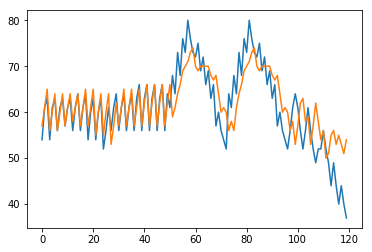

In [133]:
plt.plot(y_test.flatten())
plt.plot(predictions_3.round().flatten())

This approach seems to do a lot better in the beginning but less well 